In [1]:
import cv2
import numpy as np
import skimage.io as si
import matplotlib.pyplot as plt
from collections import Counter 

Đây là phần tiếp theo trong loạt bài `image thresholding`, [phần trước: simple thresholding](https://github.com/Nhan121/Some-statistical-GANs-simulations-drafts-/blob/master/Image_processing%20%26%20computer_vision/Image%20processing/Chapter3/simple-thresholding.ipynb).

Trong trường hợp hình ảnh có sự phân hóa lớn về cường độ sáng ở các khu vực khác
nhau thì phương pháp trên (simple thresholding) không còn phù hợp nữa, thay vào đó ta sẽ dùng
một ngưỡng giá trị tương thích với hình ảnh, và lệnh `cv2.adaptiveThreshold()` sẽ giải quyết được
vấn đề này.

Theo đó, ta sẽ có cú pháp như sau:

            cv2.adaptiveThreshold(input_img, MaxVa, adaptive_method, blocks, C)
trong đó `adaptive_method` ở đây chỉ xét 2 trường hợp là `ADAPTIVE_THRESH_MEAN_C` và `ADAPTIVE_THRESH_GAUSSIAN_C`

Trong file này, ta sẽ tìm hiểu về `ADAPTIVE_THRESH_MEAN_C` khi kết hợp cùng các `flags` trong bài luận trước đó.

Trước khi đi vào tìm hiểu chi tiết phần này, ta sẽ xem lại kết quả ở bài trước một cách sơ lược

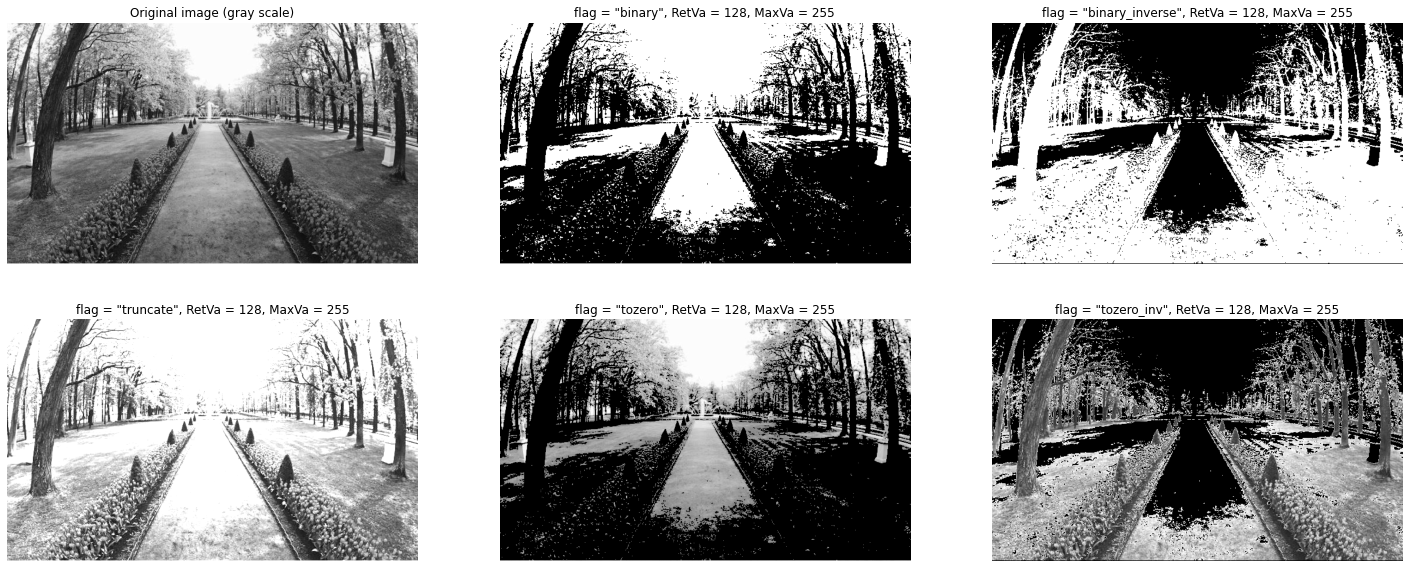

In [2]:
path = r'../input/nhabnn/mang.JPG'
image = cv2.imread(path)
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
flags = ['binary', 'binary_inverse', 'truncate', 'tozero', 'tozero_inv']
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (25, 10))
ax = ax.ravel()
for k in range(6):
    if k == 0:
        ax[k].imshow(img_gray, cmap = 'gray')
        ax[k].set_title('Original image (gray scale)')
    else:
        ret_vl, ret_img = cv2.threshold(img_gray, 128, 255, k-1)        
        ax[k].imshow(ret_img, cmap = 'gray')
        ax[k].set_title('flag = "%s", RetVa = 128, MaxVa = 255'%(flags[k - 1]))
    ax[k].set_axis_off()

## 1. ADAPTIVE_THRESH_GAUSSIAN_C
Với phương thức này, giá trị ngưỡng sẽ được tính bởi tổng các trọng số ứng với giá trị của pixel lân cận.

Như đã giới thiệu trước đó về cú pháp của `adaptive thresholding`, 2 tham số còn lại chính là:
- `blocks:` hay `blockSize` để xác đinh kích thước (`size`) của khu vực lân cận (`neighbourhood area`)
- `C`: là một hằng số được trừ vào tổng các trọng số các giá trị `pixel` của khu vực lân cận mà ta đang xét.

Lưu ý rằng `blocks` phải thỏa điều kiện sau

                (blockSize % 2 == 1) && (blockSize > 1)
                

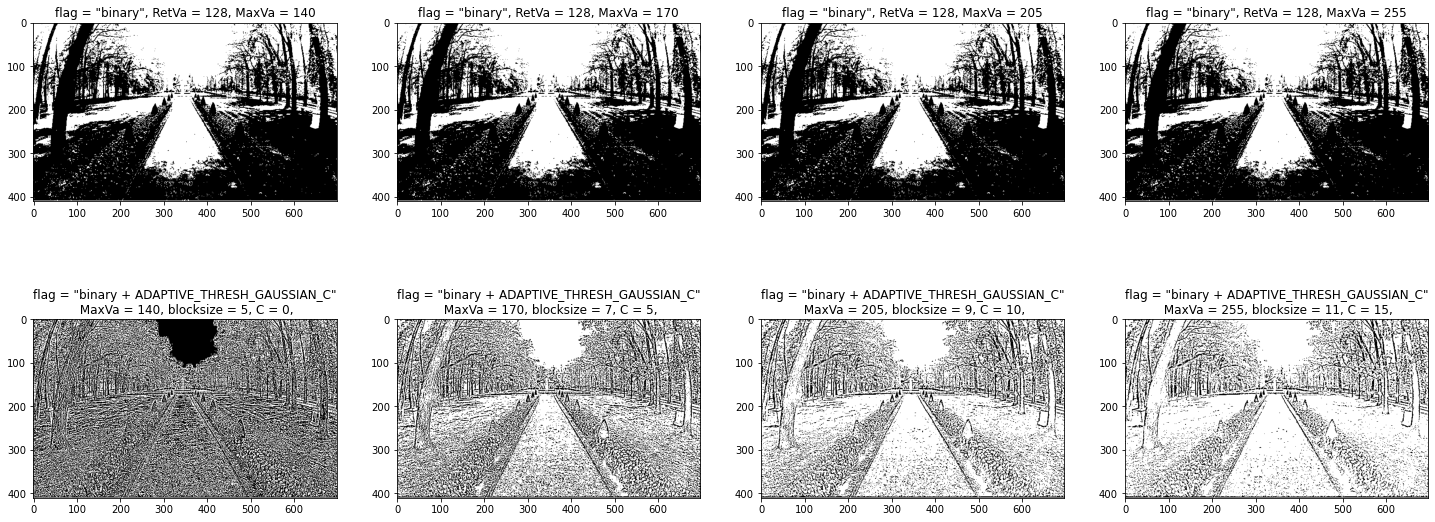

In [3]:
MaxVa = [140, 170, 205, 255]
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (25, 10))
ax = ax.ravel()
for k in range(4):
    retva, retim = cv2.threshold(img_gray, 128, MaxVa[k], cv2.THRESH_BINARY)
    thresh = cv2.adaptiveThreshold(img_gray, MaxVa[k], cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 2*k + 5, k*5)
    ax[k].imshow(retim, cmap = 'gray')
    ax[k].set_title('flag = "binary", RetVa = 128, MaxVa = %s'%(MaxVa[k]))
    ax[k + 4].imshow(thresh, cmap = 'gray')
    ax[k + 4].set_title('flag = "binary + ADAPTIVE_THRESH_GAUSSIAN_C"\n MaxVa = %s, blocksize = %s, C = %s,'%(MaxVa[k], 2*k + 5, k*5))

## 2. Ảnh hưởng của các tham số đến các flags trong `simple thresholding`
### 2.1. `flags = "cv2.THRESH_BINARY"`
Tiếp theo, ta sẽ phân tích chi tiết hơn về ảnh hưởng của mỗi tham số khi dùng kèm với `THRESH_BINARY` 

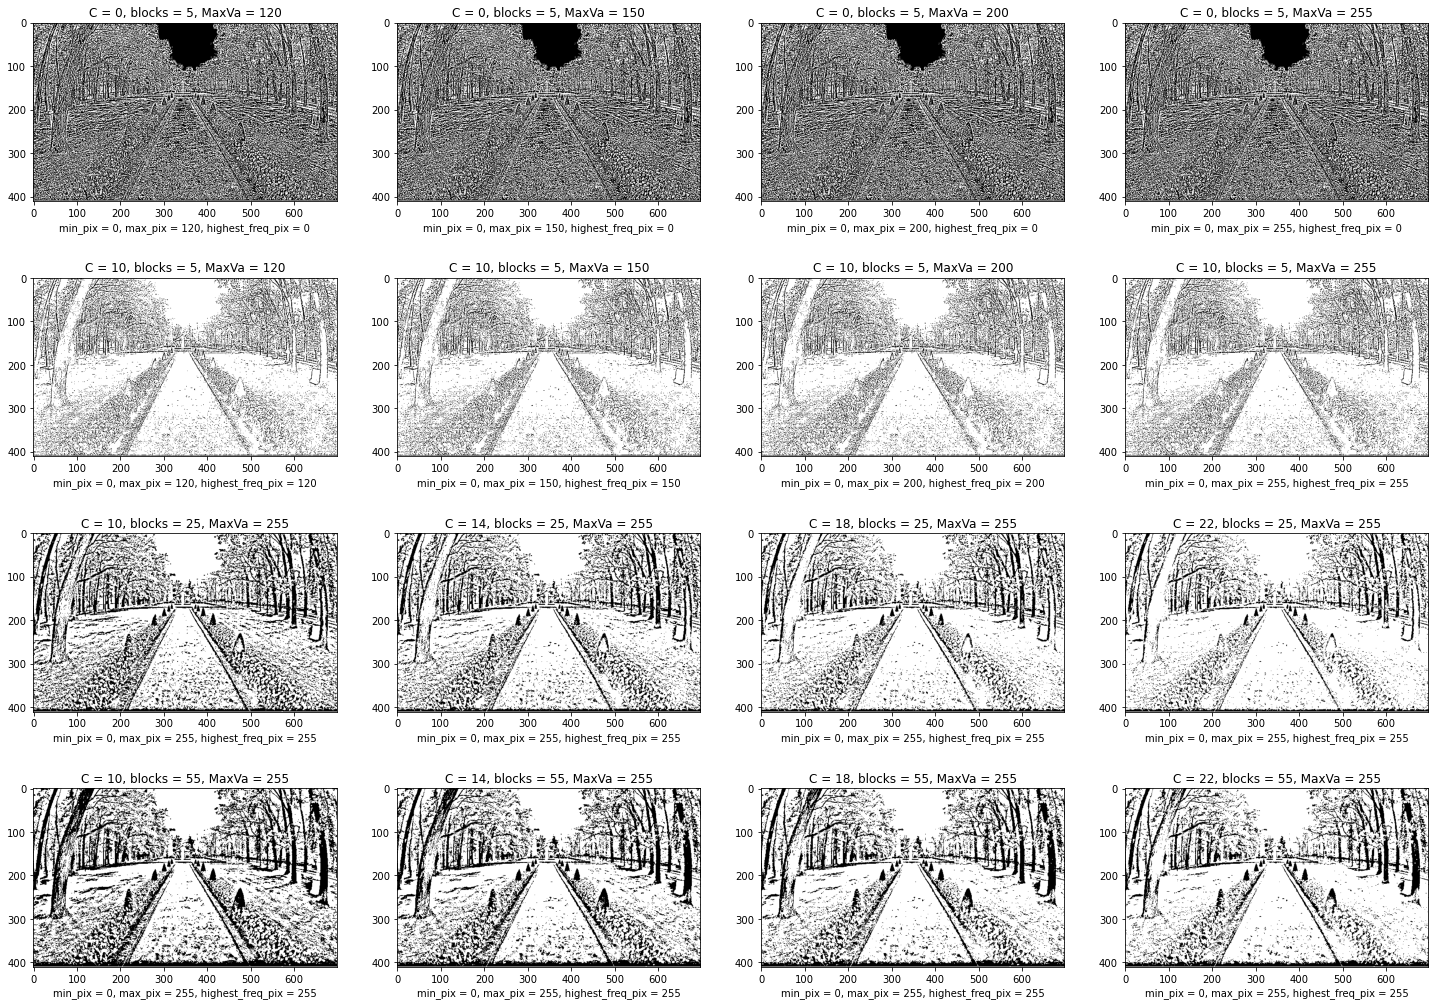

In [4]:
simple_flag = cv2.THRESH_BINARY
def minh_hoa_adaptive_thresh(img_scr, simple_flag, adaptive_flag = cv2.ADAPTIVE_THRESH_MEAN_C, cmap = 'gray'):
    MaxVa = [120, 150, 200, 255]
    fig, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (25, 18))
    ax = ax.ravel()

    for k in range(4):
        thresh_a = cv2.adaptiveThreshold(img_scr, MaxVa[k], adaptive_flag, simple_flag, 5, 0)
        ax[k].imshow(thresh_a, cmap = cmap)
        ax[k].set_title('C = 0, blocks = 5, MaxVa = %s'%(MaxVa[k]))
        ax[k].set_xlabel("min_pix = %s, max_pix = %s, highest_freq_pix = %s"%
                         (thresh_a.min(), thresh_a.max(), Counter(thresh_a.reshape(-1).ravel()).most_common(1)[0][0]))

        thresh_b = cv2.adaptiveThreshold(img_scr, MaxVa[k], adaptive_flag, simple_flag, 5, 10)
        ax[k+4].imshow(thresh_b, cmap = 'gray')
        ax[k+4].set_title('C = 10, blocks = 5, MaxVa = %s'%(MaxVa[k]))
        ax[k+4].set_xlabel("min_pix = %s, max_pix = %s, highest_freq_pix = %s"%
                         (thresh_b.min(), thresh_b.max(), Counter(thresh_b.reshape(-1).ravel()).most_common(1)[0][0]))
        
        thresh_c = cv2.adaptiveThreshold(img_scr, 255, adaptive_flag, simple_flag, 25, 10+4*k)
        ax[k+8].imshow(thresh_c, cmap = cmap)
        ax[k+8].set_title('C = %s, blocks = 25, MaxVa = 255'%(10+4*k))    
        ax[k+8].set_xlabel("min_pix = %s, max_pix = %s, highest_freq_pix = %s"%
                          (thresh_c.min(), thresh_c.max(), Counter(thresh_c.reshape(-1).ravel()).most_common(1)[0][0]))

        
        thresh_d = cv2.adaptiveThreshold(img_scr, 255, adaptive_flag, simple_flag, 55, 10+4*k)
        ax[k+12].imshow(thresh_d, cmap = cmap)
        ax[k+12].set_title('C = %s, blocks = 55, MaxVa = 255'%(10+4*k))        
        ax[k+12].set_xlabel("min_pix = %s, max_pix = %s, highest_freq_pix = %s"%
                         (thresh_d.min(), thresh_d.max(), Counter(thresh_d.reshape(-1).ravel()).most_common(1)[0][0]))

        
minh_hoa_adaptive_thresh(img_gray, simple_flag, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)

Nhận xét
- Sự thay đổi của `MaxVa` không làm ảnh hưởng đến kết quả `adaptive thresholding` (2 hàng đầu tiên) bởi những giá trị vượt ngưỡng lúc này cùng có một mức `MaxVa` và trong chế độ `cmap = "gray"` thì biểu thị về màu của nó là như nhau.
- Khi cố định `blocks`, và `C` tăng dần thì bức tranh sẽ trở nên sáng hơn bởi lượng `C (constant)` đó được trừ vào trung bình giá trị pixel trong các lân cận (nhìn hàng 3; `block = 25` và hàng 4; `block = 55`).
- Khi cố định `C` và tăng dần `blocks` thì bức tranh trở nên chi tiết hơn (cột 1 và 3 hàng cuối (với `C = 10`)
- Khi `C` đạt một mức giá trị nào đó, thì `highest_frequency_pixel (pixel có tần số cao nhất)` sẽ chính là `MaxVa` do có đại đa số `pixel` đã vượt ngưỡng này.

### 2.2. `Flag = "binary_inv"`
Tương tự như những gì đã luận ở bài trước, `binary_inv` sẽ cho kết quả tương phản với `flag = binary`, sau đây ta sẽ xem kết quả minh họa.

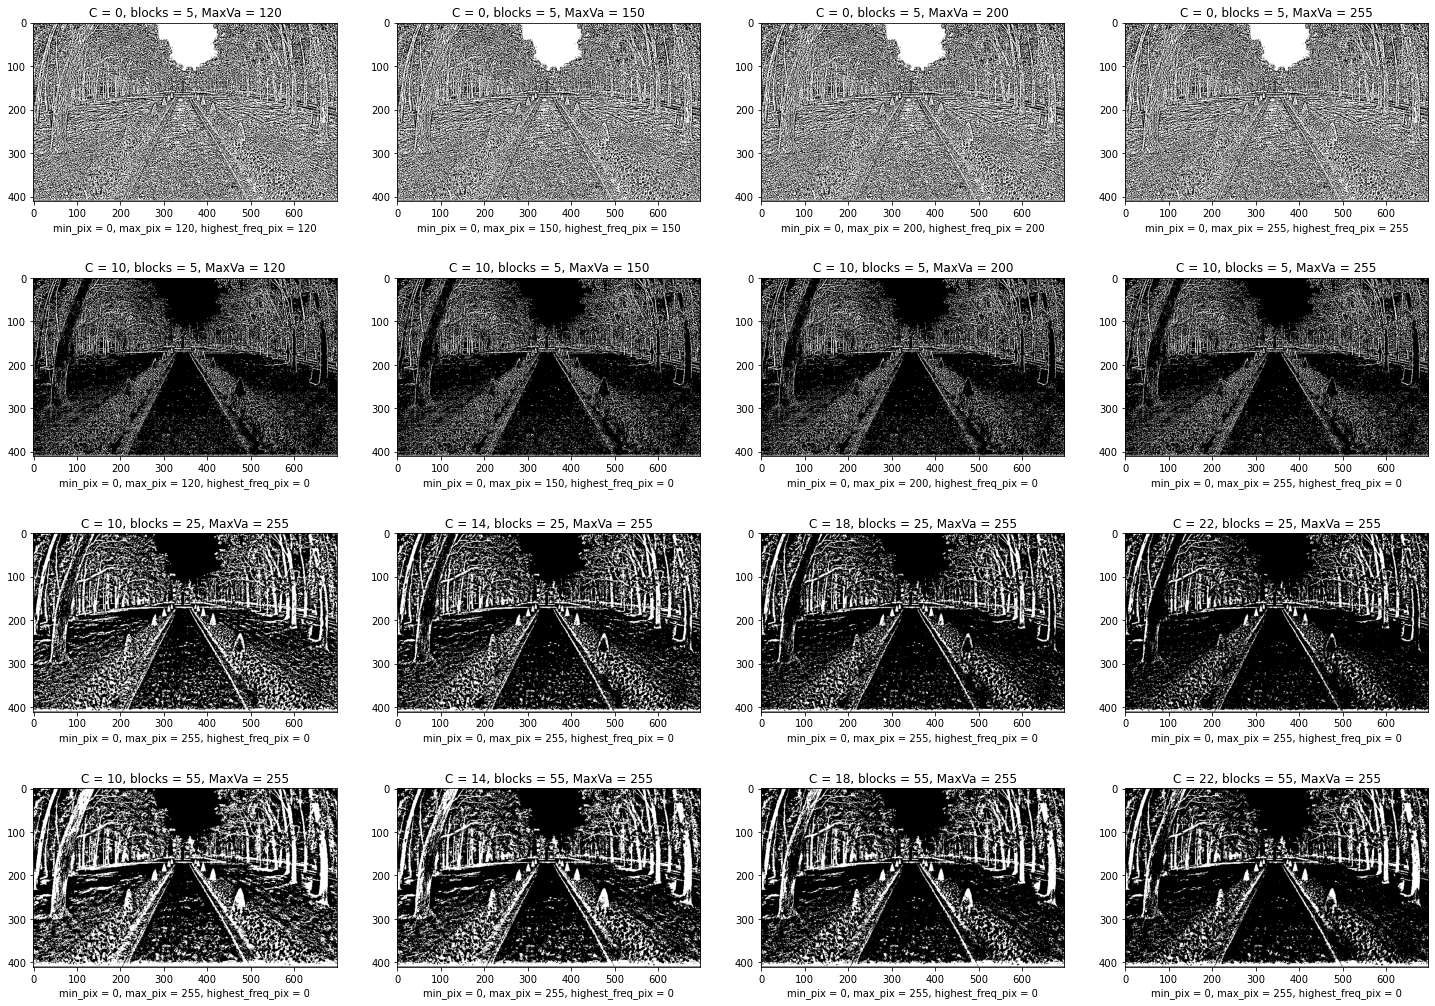

In [5]:
simple_flag = cv2.THRESH_BINARY_INV
minh_hoa_adaptive_thresh(img_gray, simple_flag, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)

### 2.3. `Flag = "Truncate, Tozero, Tozero_inv"`
Lưu ý rằng 3 flag này không được hỗ trợ khi dùng kèm với `cv2.adaptiveThreshold`, vì `thresholdType` hay `simple_threshold_flag` ở đây chỉ dùng cho 2 trường hợp trước.

Chúng ta có thể xem hướng dẫn sau đây,

In [6]:
help(cv2.adaptiveThreshold)

Help on built-in function adaptiveThreshold:

adaptiveThreshold(...)
    adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst]) -> dst
    .   @brief Applies an adaptive threshold to an array.
    .   
    .   The function transforms a grayscale image to a binary image according to the formulae:
    .   -   **THRESH_BINARY**
    .       \f[dst(x,y) =  \fork{\texttt{maxValue}}{if \(src(x,y) > T(x,y)\)}{0}{otherwise}\f]
    .   -   **THRESH_BINARY_INV**
    .       \f[dst(x,y) =  \fork{0}{if \(src(x,y) > T(x,y)\)}{\texttt{maxValue}}{otherwise}\f]
    .   where \f$T(x,y)\f$ is a threshold calculated individually for each pixel (see adaptiveMethod parameter).
    .   
    .   The function can process the image in-place.
    .   
    .   @param src Source 8-bit single-channel image.
    .   @param dst Destination image of the same size and the same type as src.
    .   @param maxValue Non-zero value assigned to the pixels for which the condition is satisfied
  

### 3. comparision